# Crypto Currency Arbitrage Analysis

A look at an arbitrage opportunity within an emerging market with exchange controls present. 

<p>Below is a high level analysis of a Bitcoin arbitrage that exists between South Africa and the UK. This does not constitute as investment advice.</p>
<p>The data has been collected over the past year and merely illustrates the possible arbitrage opportunities that exist between primarily developed and emerging markets where *central bank exchange control* is prevalent.</p> 

In [1]:
## Module Prep
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from plotly.offline import download_plotlyjs, init_notebook_mode
import plotly.offline as py
import plotly.graph_objs as go

## Notebook and Data Setup
%matplotlib inline
init_notebook_mode(connected=True)

### Read in the Arb Data
df = pd.read_csv('~/Documents/work_projects/arb_history.csv')
### Read in the USDZAR FX Data
usdzar = pd.read_excel('~/Documents/work_projects/usdzar_May17to18.xlsx')

## Key Risk Factors

*Assuming USD is the base currency*

* USDZAR --- This is prevalent when one moves the fiat currency
* BTCUSD --- This is prevalent when one moves the crypto currency

<p>Technically one could hedge out the above riskfactors however due to the size of the arbitrage and the length one runs the PV01s it does not make much economic sense.<p/>

<p>It is also worth noting for larger volumes one will face *Credit Counterpary Risk* --- as settlements via the Crypto Exchanges are generally T+1 and are not done via a central counterpary clearing process.</p>

<p>Funding risk is arguably negligible</p>


## Arbitrage Process 

<p>It is important to note the below process assumes one starts off with capital in South Africa.</p>
<p>It is simply easier to demonstrate the PnL generation from this starting point.</p>
1. Purchase USD with ZAR
2. Transfer USD to Bitstamp
3. Purchase BTC with USD
4. Transfer BTC to Luno
5. Purchase ZAR with BTC

### FX Purchase

So any EM FX trader worth their salt will tell you USDZAR is one of the most volatile ccy pairs, but seems USDTRY is slowly getting in on that volatility.

#### USD ZAR Risk - 2017/2018

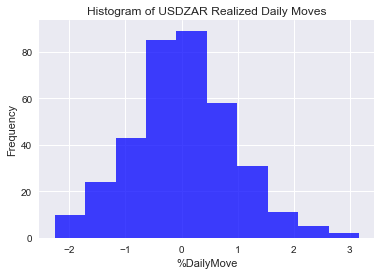

In [2]:
## Calculate & Plot Frequency of Pct Moves 
usdzar['pct_move'] = usdzar['Close'].pct_change()*100 #.rolling(window=20,center=False).std()*100

# the histogram of the data
n, bins, patches = plt.hist(usdzar['pct_move'].dropna(), facecolor='b', alpha=0.75)

plt.xlabel('%DailyMove')
plt.ylabel('Frequency')
plt.title('Histogram of USDZAR Realized Daily Moves')
plt.grid(True)
plt.show()

<p>So what does this mean --- well essentially the upper quartile is of concern, as a 2% increase in USDZAR could erode your arbitrage profits by the equivalent amount.</p>
<p>Lets consider this from a simple VaR perspective.</p>


In [3]:
alpha = 0.05
esf = 0.1
n = len(usdzar['pct_move'])
ESF90 = np.mean(np.sort(-usdzar['pct_move'],axis=0)[0:round(esf*n)])*-1
VAR95 = np.sort(-usdzar['pct_move'])[round(alpha*n)]*-1


**Based on the above yearly distribution VaR/ESF can be represented below:**

In [4]:
print("Expected Shortfall at the 90 CI {:.2f}%".format(ESF90))
print("Value at Risk at the 95 CI {:.2f}%".format(VAR95))

Expected Shortfall at the 90 CI 1.66%
Value at Risk at the 95 CI 1.51%


*2017/2018 Historically was one of the most volatile periods for the Rand*

Based on the above one can say with a 95% certainty that the **most one will lose in a day on currency devaluation is ~2%**

### Bitcoin Purchase

Now that one has purchased the USD using ZAR, the next step is to buy BTC (bitcoin) using this USD.

**This is best executed below:**
* Generally one waits for a large selloff on the day.
* Put in some bids --- *The idea is not to time the bid/ask but rather just optimise %Arb*
* The moment the bids are filled this weigthed average price is your floor.
* Immediately transfer the BTC from Bitstamp to your Luno Wallet.
 

#### BTC Risk --- Intraday

*Read in BTC ticker data from *[BitcoinCharts_API](https://bitcoincharts.com/about/markets-api/) 

In [5]:
# Read in BTC Data
import requests, csv
from datetime import datetime
#btc_url = 'https://api.blockchain.info/charts/market-price?format=json&timespan=1year'
bts_url = 'http://api.bitcoincharts.com/v1/trades.csv?symbol=bitstampUSD&start=1303100000'
r = requests.get(bts_url)
if r.status_code == 200:
    #reader = csv.DictReader(r.iter_lines())
    reader = csv.reader(r.content.decode('utf-8').splitlines(), delimiter=',')
    btcusd = []
    [btcusd.append(record) for record in reader]
else:
    print("Error with BTC Api")

In [6]:
#Create Data Frame
btcusd = pd.DataFrame(btcusd)
btcusd.columns = ['DateTimeValue','BtcUsd','Volume']
#Format the UNIX Timestamps
btcusd['local_time'] = list(map(lambda x: datetime.fromtimestamp(x),btcusd['DateTimeValue'].apply(lambda x : int(x)) ))
#btcusd['DateTime'] = list(map(lambda x: x.strftime("%Y-%m-%d %H:%M:%S.%f"),btcusd['local_time']))
btcusd.tail(3)

,DateTimeValue,BtcUsd,Volume,local_time
19997,1528465250,7585.780000000000,0.005000000000,2018-06-08 14:40:50
19998,1528465250,7585.780000000000,0.053000000000,2018-06-08 14:40:50
19999,1528465250,7585.780000000000,0.034142210000,2018-06-08 14:40:50


*In order to evaluate the **BTC Risk** we need to calculate the average confirmation time on the Blockchain*

In [7]:
### Fetch and Process Confirmation Data
blk_url = 'https://api.blockchain.info/charts/avg-confirmation-time?format=json'
r2 = r = requests.get(blk_url)
confirmation_data = r2.json()['values']
confirmation_data = pd.DataFrame(confirmation_data)
confirmation_data['DateTime'] = confirmation_data['x'].map(lambda x:  datetime.fromtimestamp(x))
confirmation_data['DateTime'] = confirmation_data['DateTime'].map(lambda x:  x.strftime("%Y-%m-%d %H:%M:%S.%f"))

In [8]:
### Plot Confirmation Data
trace1 = go.Bar(
    x = confirmation_data['DateTime'],
    y = confirmation_data['y'],
    name = 'Arb'
)
layout = go.Layout(
    title='Confirmation Time (min) on BTC Blockchain',
    xaxis=dict(
        title='Period',
        titlefont=dict(
            family='Courier New, monospace',
            size=16,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='minutes',
        titlefont=dict(
            family='Courier New, monospace',
            size=16,
            color='#7f7f7f'
        )
    )
)
data = [trace1]
fig1 = go.Figure(data=data, layout=layout)
py.iplot(fig1,filename='bar-mode')

**Based on the above one can crudely expect a confirmation time of**

In [9]:
timestep= 4
#day = list(map(lambda x: int(x),(confirmation_data.index+1)/timestep))
#weight = list(map(lambda x: x*timestep/(len(confirmation_data)+1),day))
#confirmation_data['y'].ewm(com=0.5).mean()
confirmation_data['YY'] = confirmation_data['x'].map(lambda x:  datetime.fromtimestamp(x))
confirmation_data['YY'] = confirmation_data['YY'].map(lambda x:  x.strftime("%Y"))
mean_confirmation = confirmation_data.groupby(['YY'])['y'].mean()
print("Average Confirmation Time for 2017: {:.1f} min".format(mean_confirmation['2017']))
print("Average Confirmation Time for 2018: {:.1f} min".format(mean_confirmation['2018']))

Average Confirmation Time for 2017: 141.2 min
Average Confirmation Time for 2018: 242.9 min


<p>Essentially this means one runs a BTC PV01 > 0 for conservatively 5 hrs (300min)</p> 
<p>5 hrs is used as the time to exit the position on Luno is roughly included</p>
<p>*Note this a an extremely conservative confirmation and sell off time</p>

<p>Let's evaluate an intraday BTC move</p>
<p>Due to the large amount of tick data required --- a sample is used below</p>

Maximum loss of: 1.8%


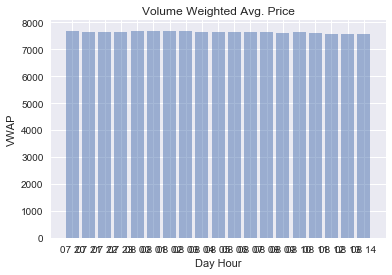

In [10]:
### Clean Ticker Data
btcusd['BtcUsd'] = pd.to_numeric(btcusd['BtcUsd'], errors='coerce').fillna(0)
btcusd['Volume'] = pd.to_numeric(btcusd['Volume'], errors='coerce').fillna(0)
#btcusd.groupby([btcusd.local_time.map(lambda t: t.hour)])['BtcUsd'].mean()
btc_clean = btcusd[['local_time','BtcUsd','Volume']].drop_duplicates()
btc_clean['DD_HH'] = btc_clean['local_time'].map(lambda x:  x.strftime("%d %H"))
#btc_clean['vol_price'] = btc_clean.apply(func=lambda r: r['BtcUsd']*r['Volume'],axis=1)
btc_group = btc_clean.groupby(['DD_HH'],as_index=True,group_keys=True)#.agg(lambda x: x['vol_price'].sum()/x['Volume'].sum())
def wavg(group):
    d = group['BtcUsd']
    w = group['Volume']
    return (d * w).sum() / w.sum()
btc_group = btc_group.apply(wavg)
#btc_clean['moves'] = btc_clean['BtcUsd'].diff(periods=3)
#np.ptp(btc_group)
print("Maximum loss of: {:.1f}%".format(np.ptp(btc_group)/btc_group[0]*100))
y_pos = np.arange(len(btc_group))
plt.bar(y_pos,btc_group, align='center', alpha=0.5)
plt.xticks(y_pos, btc_group.index)
plt.ylabel('VWAP')
plt.xlabel('Day Hour')
plt.title('Volume Weighted Avg. Price')
plt.show()

### Summary of Downside Risk

* Based on the above conservative estimatations:
    * USDZAR we can expect an extreme downside of 1.6%
    * BTCUSD we can expect an extreme downside of 2.4% 

<p>This implies a **downside tail risk of ~4%** </p>
## Is the Arbitrage large enough to account for this risk ?

In [11]:
## Data Prep -- clean intra day BTC ARB analysis
df['YR_MM'] = df['DateTime'].map(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M").strftime("%Y-%m"))
df['HOUR']  = df['DateTime'].map(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M").strftime("%H:%M"))
df['Date'] = df['DateTime'].map(lambda x:  datetime.strptime(x,"%Y-%m-%d %H:%M").strftime("%Y-%m-%d"))
df['DT_OBJ'] = df['DateTime'].map(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M"))
df['Num_Arb'] = df['Arb'].map(lambda x: float(x[:-1]))
df.tail(2)

,DateTime,Arb,YR_MM,HOUR,Date,DT_OBJ,Num_Arb
3320,2018-03-31 21:00,3.09%,2018-03,21:00,2018-03-31,2018-03-31 21:00:00,3.09
3321,2018-04-01 13:00,3.06%,2018-04,13:00,2018-04-01,2018-04-01 13:00:00,3.06


In [12]:
trace1 = go.Scatter(
    x = df['DateTime'],
    y = df['Num_Arb'],
    mode = 'lines+markers',
    name = 'Arb'
)
layout = go.Layout(
    title='Arbitrage %Size Over 2017/2018',
    xaxis=dict(
        title='Period',
        titlefont=dict(
            family='Courier New, monospace',
            size=16,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='%Arb Size',
        titlefont=dict(
            family='Courier New, monospace',
            size=16,
            color='#7f7f7f'
        )
    )
)
data = [trace1]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter-mode')

<p>The above plot is the %Arb size every hour for the last 250 days</p>
<p>**Simplified what is the expected Arb each month ?**</p>

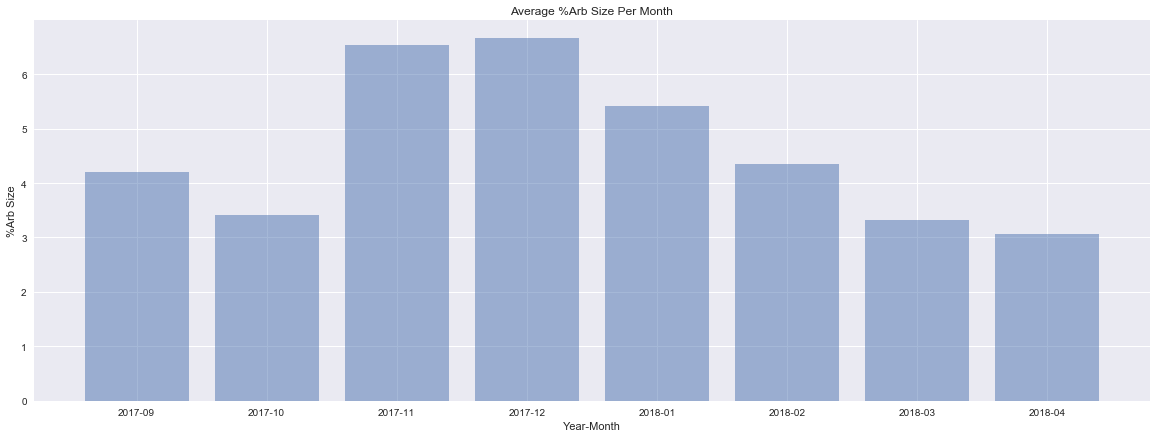

In [13]:
dfgroup = df.groupby('YR_MM')['Num_Arb'].mean()
y_pos = np.arange(len(dfgroup))
plt.rcParams["figure.figsize"] = (20,7)
plt.bar(y_pos,dfgroup, align='center', alpha=0.5)
plt.xticks(y_pos, dfgroup.index)
plt.ylabel('%Arb Size')
plt.xlabel('Year-Month')
plt.title('Average %Arb Size Per Month')
plt.show()

**What is the Frequency Distribution of the Arb**

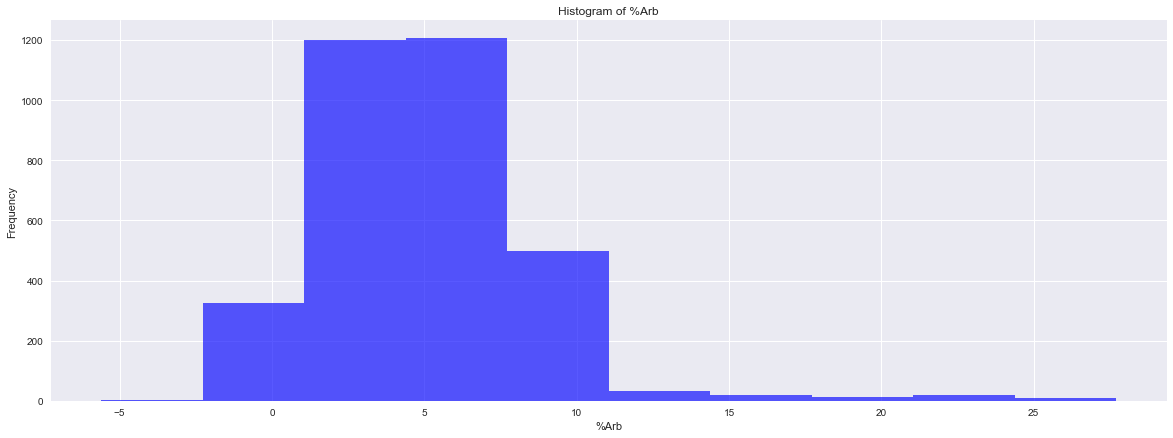

In [14]:
# the histogram of the data
n, bins, patches = plt.hist(df['Num_Arb'].dropna(), facecolor='b', alpha=0.65)

plt.xlabel('%Arb')
plt.ylabel('Frequency')
plt.title('Histogram of %Arb')
plt.grid(True)
plt.show()

## Conclusion

Based on the above high level anlysis:
* USDZAR and BTCUSD Risk is negligible as long as the Arb is above 4%
* Due to the settlement period of the FX, generally two cycles can be done daily.
* This implies a daily return of ~5%

*It is worth noting due to the lack of liquidity on Luno and the exchange controls smaller sums of capital are best used. There is also a fair amount of analytics left out in terms of association analysis between the arb and various factors such as trading activity on Luno and USDZAR.*

In [15]:
## BY REUBEN KADE ##
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }

code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')